In [1]:
# Nash Cascade Neural Network
# A hydrologically intuitive deep learning network

# Set up a solution to a network of buckets where the number of buckets in each layer
# flows out to the buckets in the next layer
# The parameter on each bucket is the size and height of each spigot.

# Need a function that solves this individually at a single buckets
# Then a function that loops through and moves the water to the downstream buckets

In [2]:
import torch
import numpy as np
import copy
import matplotlib.pyplot as plt
from ncn_fcnn import NashCascadeNetwork as ncn
from ncn_fcnn import train_model as train_ncnn
import matplotlib.font_manager as font_manager
# Precipitation standard variable name used in the ncnn model interface
PRECIP_SVN = "atmosphere_water__liquid_equivalent_precipitation_rate"
PRECIP_SVN_SEQ = "atmosphere_water__liquid_equivalent_precipitation_rate_seq"
PRECIP_RECORD = "atmosphere_water__liquid_equivalent_precipitation_rate_record"
DO_PLOT = True
N_TIMESTEPS = 300

In [3]:
network_precip_input_list = []
count = 0
unit_precip = 6.0
for i in range(N_TIMESTEPS):

    ###########################################################################
    if count == 0:
        network_precip_input_list.append(unit_precip)
    elif count > 45:
        network_precip_input_list.append(unit_precip)
    else:
        network_precip_input_list.append(np.random.random()*unit_precip/10)
    if count == 50:
        count = 0
    count+=1
    ###########################################################################
network_precip_tensor = torch.tensor(network_precip_input_list, requires_grad=False)
total_mass_precip_in = torch.sum(network_precip_tensor)

In [4]:
# Example 0
bucket_net = ncn(cfg_file="./config_0.json")
bucket_net.initialize()
bucket_net.unit_precip = unit_precip
bucket_net.summarize_network()
inital_mass_in_network = torch.sum(torch.tensor([tensor.item() for tensor in bucket_net.sum_H_per_layer]))
print(f"Initial Mass in network at start: {inital_mass_in_network:.1f}")
network_outflow_list_0 = []
for i in range(N_TIMESTEPS):

    ###########################################################################
    ###########################################################################
    bucket_net.set_value(PRECIP_SVN, torch.tensor(network_precip_input_list[i], requires_grad=False))
    bucket_net.update()
    network_outflow_list_0.append(bucket_net.network_outflow.item())
    bucket_net.summarize_network()
    ###########################################################################
    ###########################################################################

network_outflow_tensor_0 = torch.tensor(network_outflow_list_0, requires_grad=True)
bucket_net.report_out_mass_balance()
bucket_net.theta.detach()


Using device: cpu
--------------
-----------
-------------

INITIAL THETA VALUES
tensor([0.5349, 0.5402, 0.5022, 0.5169, 0.5294], requires_grad=True)
--------------
-----------
-------------

Initial Mass in network at start: 20.0
Initial Mass in network: 20.0
Final Mass in network: 36.4
Total Mass out of network 245.6
Total precipitation into network 262.0
Mass balance for network is -0.000


tensor([0.5349, 0.5402, 0.5022, 0.5169, 0.5294])

In [5]:
#print(thislinewillstopthenotebookfromgoinganyfurther)

In [6]:
# Example 1
bucket_nn = ncn(cfg_file="./config_1_fcnn.json")
bucket_nn.initialize()
bucket_nn.to(bucket_nn.device)
bucket_nn.unit_precip = unit_precip
print("Initialized")
inital_mass_in_network = torch.sum(torch.stack(bucket_nn.sum_H_per_layer)).item()
print(f"Initial Mass in network at start: {inital_mass_in_network:.1f}")
network_outflow_list_1a = []

for i in range(N_TIMESTEPS):
    # Set the current precipitation value
    bucket_nn.set_value(PRECIP_SVN, torch.tensor(network_precip_input_list[i], requires_grad=True).to(bucket_nn.device))

    # Update the network (this should internally prepare and use the FCNN inputs)
    bucket_nn.update()
    network_outflow_list_1a.append(bucket_nn.network_outflow.item())
    bucket_nn.summarize_network()
    ###########################################################################
    ###########################################################################

###########################################################################
bucket_nn.report_out_mass_balance()

origional_bucket_theta = copy.deepcopy(bucket_nn.theta.detach())


Using device: cpu
--------------
-----------
-------------

INITIAL THETA VALUES
tensor([0.9957, 0.9947, 0.9961, 0.9927, 0.9942], requires_grad=True)
--------------
-----------
-------------

Initialized
Initial Mass in network at start: 20.0
Initial Mass in network: 20.0
Final Mass in network: 44.0
Total Mass out of network 238.0
Total precipitation into network 262.0
Mass balance for network is -0.000


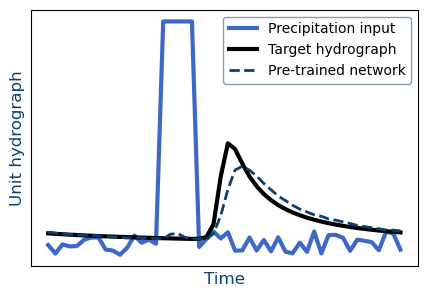

In [7]:
startplt = 230
endplt = 280
bigfontsize = 12
smallfontsize = 10
# Set figure size to 7 inches wide
figure_width = 5  # inches
aspect_ratio = 3 / 2  # Adjust as needed for your plot
figure_height = figure_width / aspect_ratio

plt.figure(figsize=(figure_width, figure_height))

# Set color
light_blue_color = "#3D68CA"
line_and_text_color = "#0D3F6E"

# Plot each series with specified color
plt.plot(network_precip_input_list[startplt:endplt], c=light_blue_color, lw=3, label="Precipitation input")
plt.plot(network_outflow_list_0[startplt:endplt], c="k", lw=3, label="Target hydrograph ")
plt.plot(network_outflow_list_1a[startplt:endplt], "--", lw=2, c=line_and_text_color, label="Pre-trained network")

network_precip_tensor = torch.tensor(network_precip_input_list)
max_value = torch.max(network_precip_tensor[startplt:endplt]).item()

plt.yticks([])
plt.xticks([])
plt.ylabel("Unit hydrograph", fontsize=bigfontsize, color=line_and_text_color)
plt.xlabel("Time", fontsize=bigfontsize, color=line_and_text_color)

# Modify legend to have a transparent background
plt.legend(fontsize=smallfontsize, edgecolor=line_and_text_color, framealpha=0.5)  # Adjust framealpha as needed

#    plt.title("Flow out from network and precip", fontsize=bigfontsize, color=line_and_text_color)

# Save the figure with transparent background and at 300 DPI
plt.show()
#plt.savefig("ncn_plot.png", transparent=True, dpi=300)

plt.close()

In [8]:
# print(thislinewillstopthenotebookfromrunningthecellsbelow)

In [9]:
bucket_nn.set_value(PRECIP_RECORD, torch.tensor(network_precip_input_list, requires_grad=False))
y_pred, loss = train_ncnn(bucket_nn, network_precip_tensor, network_outflow_tensor_0)


INITIAL MODEL theta: tensor([0.5086, 0.4064, 0.3743, 0.4833, 0.5188], grad_fn=<SigmoidBackward0>)


/Users/jmframe/miniconda3/envs/bmi_lstm/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


0.0889:loss  ----- Training EPOCH 0 --- theta: tensor([0.5086, 0.4064, 0.3743, 0.4833, 0.5188], grad_fn=<SigmoidBackward0>)
Num non-zero gadients: 1, indices: 4, gradients: -0.0071702986024320126
0.0739:loss  ----- Training EPOCH 1 --- theta: tensor([0.4853, 0.6511, 0.5753, 0.3569, 0.5595], grad_fn=<SigmoidBackward0>)
Num non-zero gadients: 1, indices: 4, gradients: 0.006347618531435728
0.4562:loss  ----- Training EPOCH 2 --- theta: tensor([0.4475, 0.4951, 0.5661, 0.1538, 0.1055], grad_fn=<SigmoidBackward0>)
Num non-zero gadients: 1, indices: 4, gradients: 0.036698952317237854
0.4052:loss  ----- Training EPOCH 3 --- theta: tensor([0.3272, 0.2379, 0.4466, 0.2627, 0.0717], grad_fn=<SigmoidBackward0>)
Num non-zero gadients: 1, indices: 4, gradients: 0.043352480977773666
0.3574:loss  ----- Training EPOCH 4 --- theta: tensor([0.1910, 0.2580, 0.3668, 0.4416, 0.0882], grad_fn=<SigmoidBackward0>)
Num non-zero gadients: 1, indices: 4, gradients: 0.018256958574056625
0.1754:loss  ----- Training 

In [10]:

network_outflow_list_1b = list(y_pred.cpu().detach().numpy())
print(bucket_net.theta)
print(bucket_nn.theta)

tensor([0.5349, 0.5402, 0.5022, 0.5169, 0.5294], requires_grad=True)
tensor([0.9792, 0.5927, 0.4159, 0.8222, 0.9949], grad_fn=<SigmoidBackward0>)


In [11]:
print("Module parameter device:", next(bucket_nn.parameters()).device)

Module parameter device: cpu


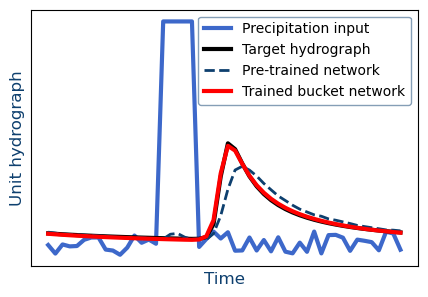

In [12]:
startplt = 230
endplt = 280
bigfontsize = 12
smallfontsize = 10
# Set figure size to 7 inches wide
figure_width = 5  # inches
aspect_ratio = 3 / 2  # Adjust as needed for your plot
figure_height = figure_width / aspect_ratio

plt.figure(figsize=(figure_width, figure_height))

# Set color
light_blue_color = "#3D68CA"
line_and_text_color = "#0D3F6E"

# Plot each series with specified color
plt.plot(network_precip_input_list[startplt:endplt], c=light_blue_color, lw=3, label="Precipitation input")
plt.plot(network_outflow_list_0[startplt:endplt], c="k", lw=3, label="Target hydrograph ")
plt.plot(network_outflow_list_1a[startplt:endplt], "--", lw=2, c=line_and_text_color, label="Pre-trained network")
plt.plot(network_outflow_list_1b[startplt:endplt], lw=3, c="r", label="Trained bucket network")

network_precip_tensor = torch.tensor(network_precip_input_list)
max_value = torch.max(network_precip_tensor[startplt:endplt]).item()
#    plt.ylim([0, max_value * 1.2])

plt.yticks([])
plt.xticks([])
plt.ylabel("Unit hydrograph", fontsize=bigfontsize, color=line_and_text_color)
plt.xlabel("Time", fontsize=bigfontsize, color=line_and_text_color)

# Modify legend to have a transparent background
plt.legend(fontsize=smallfontsize, edgecolor=line_and_text_color, framealpha=0.5)  # Adjust framealpha as needed

#    plt.title("Flow out from network and precip", fontsize=bigfontsize, color=line_and_text_color)

# Save the figure with transparent background and at 300 DPI
plt.show()
#plt.savefig("ncn_plot.png", transparent=True, dpi=300)

plt.close()



In [13]:
bucket_net.network

{0: {'H': tensor([14.2887], grad_fn=<ViewBackward0>),
  'S': tensor([[[0.4963, 0.7682],
           [0.0885, 0.1320]]]),
  's_q': tensor([[5.4958e+00, 1.0207e-03]], grad_fn=<SliceBackward0>)},
 1: {'H': tensor([13.7698,  2.2365], grad_fn=<ViewBackward0>),
  'S': tensor([[[0.3074, 0.6341]],
  
          [[0.4901, 0.8964]]]),
  's_q': tensor([[1.2234],
          [0.3988]], grad_fn=<SliceBackward0>)},
 2: {'H': tensor([6.1372], grad_fn=<ViewBackward0>),
  'S': tensor([[[0.4556, 0.6323]]]),
  's_q': tensor([[0.4257]], grad_fn=<SliceBackward0>)}}

In [14]:
bucket_nn.network

{0: {'H': tensor([16.2895], grad_fn=<ViewBackward0>),
  'S': tensor([[[0.7576, 0.2793],
           [0.4031, 0.7347]]]),
  's_q': tensor([[1.4970e-05, 5.6938e+00]], grad_fn=<SliceBackward0>)},
 1: {'H': tensor([ 9.6348, 15.4595], grad_fn=<ViewBackward0>),
  'S': tensor([[[0.0293, 0.7999]],
  
          [[0.3971, 0.7544]]]),
  's_q': tensor([[2.0313],
          [0.3898]], grad_fn=<SliceBackward0>)},
 2: {'H': tensor([83.4044], grad_fn=<ViewBackward0>),
  'S': tensor([[[0.5695, 0.4388]]]),
  's_q': tensor([[0.4084]], grad_fn=<SliceBackward0>)}}

In [15]:
bucket_net.theta

tensor([0.5349, 0.5402, 0.5022, 0.5169, 0.5294], requires_grad=True)

In [16]:
bucket_nn.theta

tensor([0.9792, 0.5927, 0.4159, 0.8222, 0.9949], grad_fn=<SigmoidBackward0>)

In [17]:
origional_bucket_theta

tensor([0.5086, 0.4064, 0.3743, 0.4833, 0.5188])

In [18]:
torch.sum(bucket_nn.theta - origional_bucket_theta)

tensor(1.5136, grad_fn=<SumBackward0>)

In [19]:
bucket_nn.theta - origional_bucket_theta

tensor([0.4706, 0.1863, 0.0416, 0.3390, 0.4761], grad_fn=<SubBackward0>)

In [20]:
print(thislinewillstopthenotebookfromrunningthecellsbelow)

NameError: name 'thislinewillstopthenotebookfromrunningthecellsbelow' is not defined

In [ ]:
import numpy as np
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
from torch.autograd import Variable 
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Using CUDA device: ", torch.cuda.get_device_name(0))
else:
    device = 'cpu'

In [ ]:
# Convert arrays to PyTorch tensors
x_input = torch.FloatTensor(network_precip_tensor.detach().numpy())
y_target = torch.FloatTensor(network_outflow_tensor_0.detach().numpy())

# Define the sequence length (you can adjust this)
seq_length = 12

# Function to create sequences
def create_sequences(input_data, target_data, seq_length):
    xs, ys = [], []
    for i in range(len(input_data)-seq_length):
        x_seq = input_data[i:i+seq_length]
        y_seq = target_data[i+seq_length]
        xs.append(x_seq)
        ys.append(y_seq)
    return torch.stack(xs), torch.stack(ys)

X, y = create_sequences(x_input, y_target, seq_length)

class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=256, output_size=1, num_layers=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers=num_layers)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq.view(len(input_seq), 1, -1))
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

model = LSTMModel()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 5
for epoch in range(epochs):
    for seq, labels in zip(X, y):
        optimizer.zero_grad()
        y_pred = model(seq)
        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if epoch % 1 == 0:
        print(f'epoch: {epoch} loss: {single_loss.item()}')

print(f'Final loss: {single_loss.item()}')




predictions = []
model.eval()
with torch.no_grad():
    for seq in X:
        predictions.append(model(seq).item())

# Convert predictions to a numpy array for easy plotting
predictions_np = np.array(predictions)
plt.figure(figsize=(12, 6))
plt.title("LSTM Predictions vs Actual Data")
plt.xlabel("Time Steps")
plt.ylabel("Output")
plt.plot(x_input.numpy()[seq_length:], label='Precipitation', alpha=0.7)
plt.plot(y_target.numpy()[seq_length:], label='Actual Outflow', alpha=0.7)
plt.plot(predictions_np, label='Predicted Outflow', alpha=0.7, linestyle='--')
plt.legend()
plt.show()


In [ ]:
# Convert arrays to PyTorch tensors
x_input = torch.FloatTensor(network_precip_tensor.detach().numpy())
y_target = torch.FloatTensor(network_outflow_tensor_0.detach().numpy())

# Define the sequence length (you can adjust this)
seq_length = 35

# Function to create sequences
def create_sequences(input_data, target_data, seq_length):
    xs, ys = [], []
    for i in range(len(input_data) - seq_length):
        x_seq = input_data[i:i + seq_length]
        y_seq = target_data[i + seq_length]
        xs.append(x_seq)
        ys.append(y_seq)
    return torch.stack(xs), torch.stack(ys)

X, y = create_sequences(x_input, y_target, seq_length)

# Feedforward Neural Network Model
class FFNNModel(nn.Module):
    def __init__(self, input_size, hidden_layer_size=3, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        # Define your feedforward layers here
        self.fc1 = nn.Linear(input_size, hidden_layer_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_layer_size, hidden_layer_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_layer_size, hidden_layer_size)
        self.fc4 = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        self.activations = []
        x = self.fc1(input_seq)
        self.activations.append(x.detach().numpy())  # Record activation
        x = self.relu1(x)
        self.activations.append(x.detach().numpy())  # Record activation
        x = self.fc2(x)
        self.activations.append(x.detach().numpy())  # Record activation
        x = self.relu2(x)
        self.activations.append(x.detach().numpy())  # Record activation
        x = self.fc3(x)
        self.activations.append(x.detach().numpy())  # Record activation
        predictions = self.fc4(x)
        return predictions[-1]

model = FFNNModel(input_size=seq_length)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.006)
scheduler = StepLR(optimizer, step_size=1, gamma=0.99, verbose=True)

epochs = 150
for epoch in range(epochs):
    for seq, labels in zip(X, y):
        optimizer.zero_grad()
        y_pred = model(seq)
        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()
    
    scheduler.step()
    if epoch % 1 == 0:
        print(f'epoch: {epoch} loss: {single_loss.item():.4f}')

print(f'Final loss: {single_loss.item()}')

In [ ]:
x_input.shape, y_target.shape, predictions_np.shape

In [ ]:
predictions = []
model.eval()
with torch.no_grad():
    for i, seq in enumerate(X):
        predictions.append(model(seq).item())
predictions_np = np.array(predictions)

DO_PLOT = True
if DO_PLOT:
    startplt = 230
    endplt = 280
    bigfontsize = 22
    smallfontsize = 16
    # Set figure size to 7 inches wide
    figure_width = 7  # inches
    aspect_ratio = 3 / 2  # Adjust as needed for your plot
    figure_height = figure_width / aspect_ratio

    plt.figure(figsize=(figure_width, figure_height))

    # Set color
    light_blue_color = "#3D68CA"
    line_and_text_color = "#0D3F6E"

    # Plot each series with specified color
    plt.plot(network_precip_input_list[startplt:endplt], c=light_blue_color, lw=10, label="Precipitation input")
    plt.plot(network_outflow_list_0[startplt:endplt], c="k", lw=10, label="Target hydrograph ")
    # plt.plot(network_outflow_list_1a[startplt:endplt], "--", lw=5, c=line_and_text_color, label="Pre-trained network")
    plt.plot(predictions_np[startplt-seq_length:endplt-seq_length], "--", lw=10, c=line_and_text_color, label="Trained bucket network")

    network_precip_tensor = torch.tensor(network_precip_input_list)
    max_value = torch.max(network_precip_tensor[startplt:endplt]).item()
    plt.ylim([0, max_value * 1.2])

    plt.yticks([])
    plt.xticks([])
    plt.ylabel("Unit hydrograph", fontsize=bigfontsize, color=line_and_text_color)
    plt.xlabel("Time", fontsize=bigfontsize, color=line_and_text_color)

    # Modify legend to have a transparent background
    #plt.legend(fontsize=smallfontsize, edgecolor=line_and_text_color, framealpha=0.5)  # Adjust framealpha as needed

    #plt.title("Flow out from network and precip", fontsize=bigfontsize, color=line_and_text_color)

    # Save the figure with transparent background and at 300 DPI
    #plt.show()
    plt.savefig("./figs/ffn_plot.png", transparent=True, dpi=300)

    plt.close()

def plot_the_time_series(x_input, y_target, predictions_np, seq_length):
    plt.figure(figsize=(12, 6))
    plt.title("FFNN Predictions vs Actual Data")
    plt.xlabel("Time Steps")
    plt.ylabel("Output")
    plt.plot(x_input.numpy()[seq_length:], label='Precipitation', alpha=0.7)
    plt.plot(y_target.numpy()[seq_length:], label='Actual Outflow', alpha=0.7)
    plt.plot(predictions_np, label='Predicted Outflow', alpha=0.7, linestyle='--')
    plt.legend()
    plt.show()
    plt.close()
predictions = []
model.eval()
with torch.no_grad():
    for i, seq in enumerate(X):
        predictions.append(model(seq).item())
predictions_np = np.array(predictions)
plot_the_time_series(x_input, y_target, predictions_np, seq_length)

In [ ]:
import imageio
import seaborn as sns
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable

In [ ]:
#print(thiscellwillstopthenotebookbeforetheanimationismade)

In [ ]:
def visualize_layer_connections_with_annotations(model, input_seq, title):
    model(input_seq)  # Forward pass to record activations
    activations = model.activations

    # Concatenate activations horizontally
    concatenated_activations = np.hstack([activation.reshape(-1, 1) for activation in activations])

    # Plotting
    plt.figure(figsize=(3, 2))  # Adjust the figure size as needed
    ax = sns.heatmap(concatenated_activations, annot=True, fmt=".2f", cmap="viridis", annot_kws={"size": 8})
    plt.title(title)
    plt.xlabel("Layer Neurons")
    plt.ylabel("Activation")
    plt.show()

# Usage
for i in [50, 75]:
    visualize_layer_connections_with_annotations(model, X[i], f"Neuron Connections at x={i}")


In [ ]:
def network_visualization_subplot(model, input_seq, layer_sizes, title, ax):
    model(input_seq)  # Forward pass to record activations
    activations = model.activations

    # Create a color map
    cmap = plt.get_cmap('viridis')

    # Normalize the activation values to [-5, 5] for the color map
    norm = mcolors.Normalize(vmin=-5, vmax=5)

    # Number of layers including input and output
    num_layers = len(layer_sizes)

    # List to store node positions, to be used to draw the edges
    node_positions = {}

    # Generate positions for each layer
    for i, size in enumerate(layer_sizes):
        # Vertical positions
        v_positions = np.linspace(0, 1, size + 2)[1:-1]

        # Horizontal position
        h_position = i / (num_layers - 1)

        # Draw nodes
        for j, v in enumerate(v_positions):
            activation = 0
            if i > 0:  # Skip input layer for activations
                activation = activations[i-1][j]
            color = cmap(norm(activation))

            circle = plt.Circle((h_position, v), 0.05, color=color, zorder=4)
            ax.add_artist(circle)
            node_positions[(i, j)] = (h_position, v)

            # Optionally, add activation values as text inside the nodes
            # plt.text(h_position, v, f'{activation:.2f}', ha='center', va='center', color='white', fontsize=8)

    # Draw edges
    for i in range(num_layers - 1):
        for j in range(layer_sizes[i]):
            for k in range(layer_sizes[i + 1]):
                start_pos = node_positions[(i, j)]
                end_pos = node_positions[(i + 1, k)]
                line = plt.Line2D([start_pos[0], end_pos[0]], [start_pos[1], end_pos[1]], c='black', alpha=0.3)
                ax.add_line(line)

    mappable = ScalarMappable(norm=norm, cmap=cmap)

    # Add a colorbar
    plt.colorbar(mappable, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)

    # Set title and turn off axis
    ax.set_title(title)
    ax.axis('off')


In [ ]:
def plot_the_time_series_subplot(x_input, y_target, predictions_np, seq_length, t, ax):
    ax.set_title("FFNN Predictions vs Actual Data")
    ax.set_xlabel("Time Steps")
    ax.set_ylabel("Output")
    ax.plot(x_input.numpy()[seq_length:], label='Precipitation', alpha=0.7)
    ax.plot(y_target.numpy()[seq_length:], label='Actual Outflow', alpha=0.7)
    ax.plot(predictions_np, label='Predicted Outflow', alpha=0.7, linestyle='--')
    ax.axvline(x=t, color='red', linestyle='--')  # Vertical line
    ax.legend()

In [ ]:
# Define the size of each layer (including input and output layers)
layer_sizes = [1, 3, 3, 3, 1]  # Example: input layer with 35 nodes, three hidden layers with 3 nodes each, and an output layer with 1 node

# Usage
for t in range(1,200):

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

    # Network visualization on the first subplot
    network_visualization_subplot(model, X[t], layer_sizes, f"Neural Network Visualization at t={t}", ax1)

    # Time series plot on the second subplot
    plot_the_time_series_subplot(x_input, y_target, predictions_np, seq_length, t, ax2)

    plt.tight_layout()
    plt.savefig(f"./figs/network_plot/combined_frame_{t}.png")
    plt.close(fig)

In [ ]:
filenames = [f"./figs/network_plot/combined_frame_{t}.png" for t in range(1, 200)]
images = [imageio.imread(filename) for filename in filenames]
imageio.mimsave('network_animation.gif', images, fps=2)  # Adjust fps as needed